# Portfolio 2: Energy Use
Predicting the energy usage of a house.

This notebook will reproduce some of the experiments conducted in <a href="https://www-sciencedirect-com.simsrad.net.ocs.mq.edu.au/science/article/pii/S0378778816308970#tbl0020">this paper</a>. The approach will be:
1. Read in the data
2. Clean the data
3. Inspect & Visualise the data
4. Run a Multiple Linear Regression to predict Appliance energy use
5. Run an RFE (Recursive Feature Elimination) to determine the best features/columns to use

In [24]:
import pandas as pd
import utils
import math
import numpy as np
from matplotlib import pyplot as plt # Matplotlib for additional customization
%matplotlib inline
import seaborn as sns # Seaborn for plotting and styling
from datetime import datetime, date, time, timedelta

## 1. Read in data
There are 3 data files:
1. **enerydata_complete.csv**: the energy data in its complete form
2. **training.csv**: a 75% split of the data for training
3. **testing.csv**: a 25% split of the data for testing

In [25]:
energy = pd.read_csv("data/energydata_complete.csv", na_values='')
train = pd.read_csv("data/training.csv", na_values='')
test = pd.read_csv("data/testing.csv", na_values='')
energy.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097



## Clean the data
Count the number of nulls in the dataframe and then, incase there are NaNs, find which column it is in.

In [26]:
#count the number of nulls
print("TOTAL NUMBER OF NaN IN DATAFRAME: ", energy.isnull().sum().sum())
print("\nand checking column by column: ")
print(energy.isnull().sum())

TOTAL NUMBER OF NaN IN DATAFRAME:  0

and checking column by column: 
date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64


Since each row has a date&time attached to it, we want this to be the index. But first check its data type: is it a datetime or is it a string?

In [27]:
print(type(energy['date'][0]))

<class 'str'>


Since its a string, Convert to datetime before setting it as index

In [28]:
#convert string to datetime
energy['date']=pd.to_datetime(energy['date'])

#set 'date' column as index
energy.set_index('date', inplace=True)
energy.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


### Explore Data

Lets see how many rows and columns we are working with:

In [29]:
print("shape of data is: ",energy.shape)
print("\ncolumn names: ",energy.columns.values)
energy.describe()

shape of data is:  (19735, 28)

column names:  ['Appliances' 'lights' 'T1' 'RH_1' 'T2' 'RH_2' 'T3' 'RH_3' 'T4' 'RH_4'
 'T5' 'RH_5' 'T6' 'RH_6' 'T7' 'RH_7' 'T8' 'RH_8' 'T9' 'RH_9' 'T_out'
 'Press_mm_hg' 'RH_out' 'Windspeed' 'Visibility' 'Tdewpoint' 'rv1' 'rv2']


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,...,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,...,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,...,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,...,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,...,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,...,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


So there are 19,735 rows and 28 columns.

**Appliances**: There is a big leap in the final 25% (from output of 100 to 1080!). 

**Lights**: most don't require much energy (three quarters use 0 energy)

**Temperature**: (all the Ti where i=1-9). We can see that even though the outside temperature reaches a minimum of -5, the temperature in each room always stays above 0. 

### Pairs plot
This will plot each variable against the others showing each pair's relationship, with a distribution of each variable on the diagonal. For simplicity only the first few variables have been displayed.

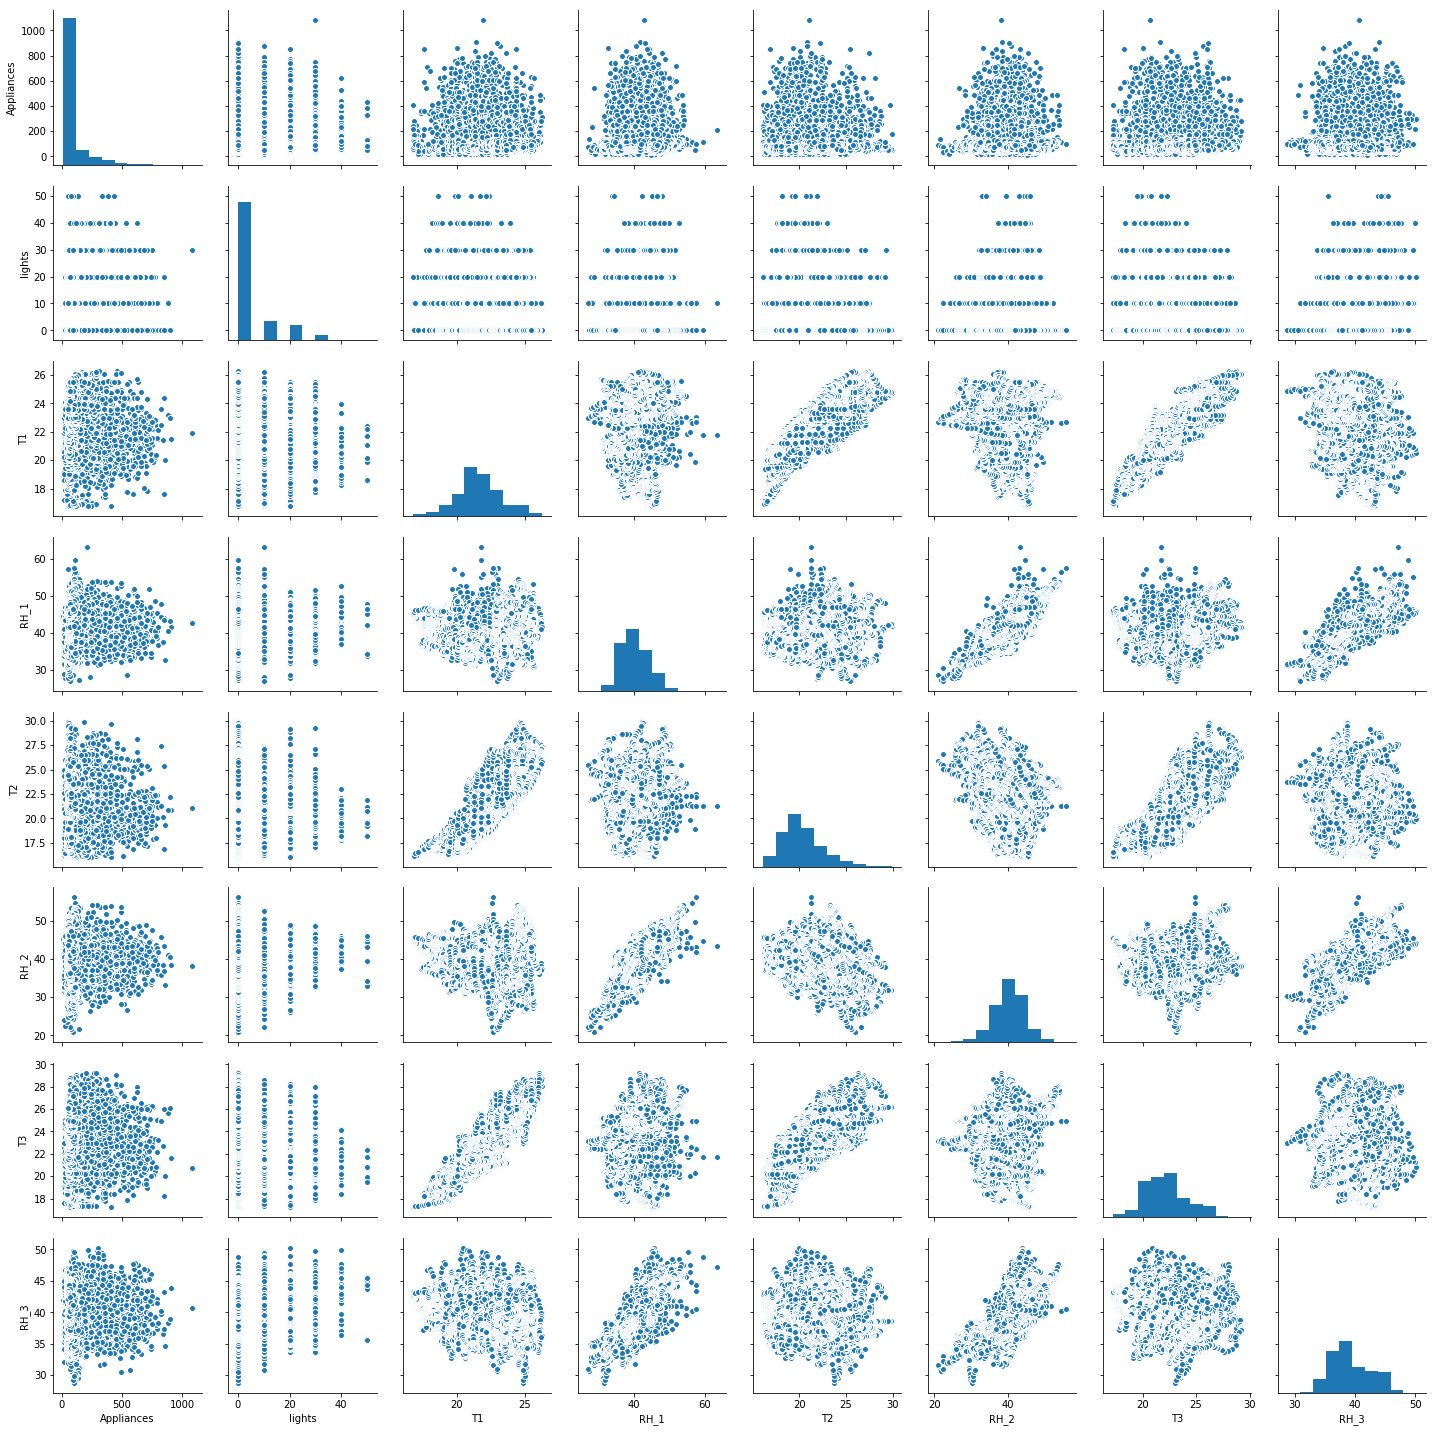

In [30]:
feature_cols = ['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3']
sns.pairplot(train[feature_cols])

From the plots above we can see observe:
* There is right-skew in 'Appliances' and 'lights'
* the rest of the data appears normally distributed. 
* There is a positive linear relationships between the different T's as well as between the different RH which makes sense as these are all measures of the temperature and relative humidity from different rooms. It makes sense that these would correlate
* The scatter appears quite random when look at T's and RH's suggesting that temperature and relative humidity is not related. 

## Multiple Linear Regression
###    split the data into x and y:
The data is already split but here we separate the training data into our X and y as well as splitting the testing data into our X and y. 

Next I will check the split of training/test data to confirm the split ratio. 

In [31]:
print("number of rows in complete data is ",len(energy))
print("number of rows in training data is {0} i.e. {1:.0f}%".format(len(train),len(train)/len(energy)*100))
print("number of rows in test data is {0} i.e. {1:.0f}%".format(len(test),len(test)/len(energy)*100))

number of rows in complete data is  19735
number of rows in training data is 14803 i.e. 75%
number of rows in test data is 4932 i.e. 25%


So we know that the train/test is split correctly into a 75% : 25% ratio. Now lets allocate the training and testing data to some variables for use in our models. 

In [32]:
feature_cols=energy.columns.values[1:] #all the columns except the first one(Appliances) which is our y

X_train=train[feature_cols]
y_train=train['Appliances']

X_test=test[feature_cols]
y_test=test['Appliances']

### fit, train and evaluate the model
Below I have fit a **linear regression model** using the training data. All features have been included in the model as a baseline. 

After fitting the model I then predicted results (y hat) from the X_test data. The metrics MSE (Mean Squared Error), RMSE (The square root of RMSE) and R-squared were calculated by comparing the *predicted* data with the *actual* data from Y_test

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


model=LinearRegression()
model.fit(X_train, y_train)

yhat=model.predict(X_test)

print("EVALUATION METRICS: test data")
print("MSE: ", mean_squared_error(y_test, yhat)) #(y_true, y_predict)
print("RMSE = sqrt(MSE): ", mean_squared_error(y_test, yhat)**0.5)
print("R^2: ", r2_score(y_test, yhat)) #(y_true, y_predict)

EVALUATION METRICS: test data
MSE:  8779.876551614194
RMSE = sqrt(MSE):  93.7009954675733
R^2:  0.14951129278702824


The resulting metrics from the linear model show a high MSE. This is the average of the squared difference between the predicted and actual observations. We want this to be as low as possible since smaller errors mean more accuracy. 

The RMSE is an easier metric to evaluate since it is on the same scale as the Y variable `Appliances`. Since the values of `Appliances` ranges from 10-1080, an RMSE of 93 isn't too bad for a baseline model. 

The R^2 (aka the coefficient of determination) is the ratio of *explained* variation over *total* variation. It tells you how much of the variation is explained by the model. Our resulting R squares is quite low (0.149). Ideally this would be 1 (a perfect fit). A Rsquared of 0.149 tells us that the model only explains 15% of the data's variation. 

**Comparing to the paper**
These results are very similar to those found in the paper (RMSE: 93.18 and R^2: 0.16). The difference can be put down to the fact the paper used extra variables in the linear model such as NSM, Day_of_week and week status all of which would have introduced multicollinearity between the independant variables.

### Plot: Resid vs Pred
A "well behaved" resid vs fitted plot has:
* random variation around the line
* no obvious residual which STANDS OUT; this would imply an outlier

**Plots**
1. First plot is the resid vs predicted plot (What *should* be used for analysing regression)
2. Second plot is what the paper used (resid vs Appliances)

But as we see in the plot below, the variation is NOT random AND there appears to be possible outliers where residual~900.

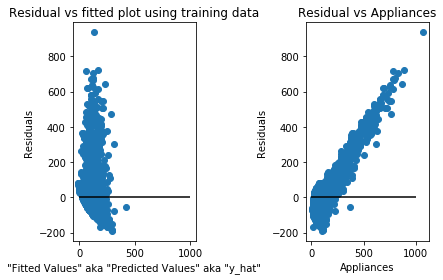

In [34]:
#calculate residuals
resids = y_test - yhat

#plot resid vs fitted
plt.subplot(1, 2, 1)
plt.scatter(x=yhat, y=resids,)
plt.hlines(y=0, xmin=0, xmax=1000)
plt.title('Residual vs fitted plot using training data')
plt.ylabel('Residuals')
plt.xlabel('\"Fitted Values\" aka \"Predicted Values\" aka \"y_hat\"')

#plot resid vs Appliances (y_test)
plt.subplot(1, 2, 2)
plt.scatter(x=y_test, y=resids,)
plt.hlines(y=0, xmin=0, xmax=1000)
plt.title('Residual vs Appliances')
plt.ylabel('Residuals')
plt.xlabel('Appliances')

plt.tight_layout()
plt.show()

There appears to be an outlier which has a residual>800. We can identify it by running the code below and find that case 359 (when residual=935) is the outlier. 

In [35]:
resids[resids>800]

359    935.839112
Name: Appliances, dtype: float64

## Recursive Feature Elimination with Cross Validation (RFECV)

Before I run an RFE on this data and model, I want to establish the optimal number of features. Below is the RFE with Cross Validation.

In [36]:
from sklearn.feature_selection import RFECV

num_variables = len(X_train.columns)

rfecv = RFECV(estimator=model, cv=3)

# Fit recursive feature eliminator 
rfecv.fit(X_train, y_train)

# Number of best features
print("After running the RFECV, there are ",rfecv.n_features_," selected features. We started with ", num_variables)

After running the RFECV, there are  11  selected features. We started with  27


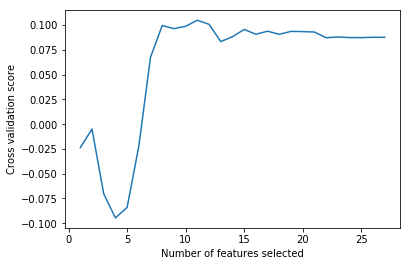

In [37]:
# Plot number of features VS. cross-validation scores
#Source: http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

After running the RFECV, we can see that 11 (out of 27) features is optimal. There is a large leap in the CV-score between  having 5 and 8 features. Its important to note that the paper which I am working off decides to choose 6 variables. To finish off this analysis I will:
- run the RFE with `n_features_to_select=1`to determine feature importance
- run the linear regression with the 6 variables as mentioned above
- run the linear regression with 11 variables (as per my RFECV) to see if this produces better metrics. 

## Recursive Feature Elimination

I ran the RFE model with the above linear model. This was run to the point that there was only 1 variable left. I then displayed the ranking of variables by converting the rfe.ranking_ to a dataframe and displaying it.

In [38]:
from sklearn.feature_selection import RFE

#feature_cols=X_train_new.columns.values[1:] #all the columns except the first one(Appliances) which is our y

#run the RFE until only 1 feature is left
rfe = RFE(model,n_features_to_select=1)
rfe.fit(X_test, y_test)

#create empty DateFrame to store rankings
df=pd.DataFrame(index=feature_cols)

#add ranking array to dataframe (by converting to a series)
df['ranking']=pd.Series(rfe.ranking_, df.index)

#sort values in ascending order
df.sort_values(by='ranking', ascending=True, inplace=True)
df

,ranking
RH_1,1
RH_2,2
T2,3
T3,4
T9,5
T8,6
T1,7
T6,8
T_out,9
RH_8,10


The paper's RFE determines that 6 features are best but from the starting point the paper's RFE has 35 variables, where as I have 27 (due to not introducing dummy variables for days of the week etc). The only common variables in my top 6 and the paper's was T3

My top 6 variables (compared to the paper's) are:

| My Top 6 | Paper's Top 6   |
|------|------|
|   RH_1  | NSM|
|   RH_2  | Lights|
|   T2  | Press|
|   T3  | RH5|
|   T9  | T3|
|   T8  | RH3|


Below are two lists which hold both the top 6 and top 11 variables. I will use these when modifying my dataframe so as to only include these in the model. 

In [40]:
top_11 = ['RH_1', 'RH_2', 'T2', 'T3', 'T9', 'T8', 'T1', 'T6', 'T_out', 'RH_8', 'T5']
top_6 = ['RH_1', 'RH_2', 'T2', 'T3', 'T9', 'T8']

Below is the linear regression with the top 11 features. First I updated the training and test X variables so as to only include the top_11 features. I then ran the model and displayed the metrics. The same was done following this but for the top_6 features. 

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X_train = X_train[top_11]
X_test = X_test[top_11]

model=LinearRegression()
model.fit(X_train, y_train)

yhat=model.predict(X_test)

print("EVALUATION METRICS for 11 features: test data")
print("MSE: ", mean_squared_error(y_test, yhat))
print("RMSE = sqrt(MSE): ", mean_squared_error(y_test, yhat)**0.5)
print("R^2: ", r2_score(y_test, yhat)) 

EVALUATION METRICS for 11 features: test data
MSE:  9049.947184879818
RMSE = sqrt(MSE):  95.13121036168845
R^2:  0.12335010220627451


In [45]:
X_train = X_train[top_6]
X_test = X_test[top_6]

model=LinearRegression()
model.fit(X_train, y_train)

yhat=model.predict(X_test)

print("EVALUATION METRICS for 6 features: test data")
print("MSE: ", mean_squared_error(y_test, yhat))
print("RMSE = sqrt(MSE): ", mean_squared_error(y_test, yhat)**0.5)
print("R^2: ", r2_score(y_test, yhat)) 

EVALUATION METRICS for 6 features: test data
MSE:  9465.48589129187
RMSE = sqrt(MSE):  97.29072870161818
R^2:  0.08309771652229103


As we can see from the metrics below, 11-features yields the best results, as expected due to the RFECV.

The Linear Regression with 11 features has an RMSE of 95 (compared to 93 in the original model). While only a small decrease, its a decrease nonetheless.

The R^2 is 0.123 which tells us that the model explains 12.3% of the variation in the data. Unfortunately this is a decrease from the original model (.145)

It is possible that overfitting has occured or that the variables need to be transformed especially the y variable as it is heavily right skewed. 